## reference : https://github.com/eriklindernoren/PyTorch-GAN
## reference : https://www.youtube.com/watch?v=sSxdQq9CCx0&t=265s

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
import os
import random
from os.path import join
from os import listdir
import glob
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as utils
import torchvision.datasets as dsets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import time
from skimage.restoration import denoise_nl_means
from scipy.signal import medfilt2d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage import io
from torchvision.transforms.functional import to_pil_image

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/tmp/ipykernel_3673753/4132361959.py:26: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_3673753/4132361959.py:27: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


In [3]:
torch.cuda.empty_cache()

In [4]:
# Set random seed for reproductibility 
manualSeed = 303
print("Random seed:",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 303


In [5]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
#DEVICE='cpu' 
device = 'cuda'
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


### make custom dataset

#### transform 종류
- 이미지 변경
- size 변경
- 이미지 tensor화
- 정규화

In [6]:
path = './COVID-19_Radiography_Dataset/COVID/images'
image_paths = glob.glob(path + '/*.png')
# 모든 png 파일 불러오기
image_paths = sorted(image_paths)

img_size = 128
batch_size = 32
transform=transforms.Compose([
                               transforms.ToPILImage(),
                               transforms.Resize(img_size),
                               transforms.ToTensor()
                           ])

In [7]:
import cv2
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        image_path = self.paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
        
        if self.transform:
            image_tensor = self.transform(image)
            
        return image_tensor
    
train_dataset = ImageDataset(image_paths[:round(len(image_paths)*0.8)], transform)
test_dataset = ImageDataset(image_paths[round(len(image_paths)*0.8):], transform)

In [8]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  drop_last=True, num_workers=1)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

### define noise

In [12]:
def add_noise(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        image = np.array(image)
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = torch.Tensor(noisy)
        return noisy
    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        noisy = torch.Tensor(noisy)
        return noisy

### hyperparameter setting

In [14]:
batch_size = 32

img_size = 128
# grayscale 임!
nc = 1 

nz = 64

ngf = 64  # 생성자를 통과하는 특징 데이터들의 채널 크기 # 걍 64가 국룰인가?

ndf = 64 # 구분자를 통과하는 특징 데이터들의 채널 크기

num_epochs = 100

lr = 0.0002

beta1 = 0.5

img_shape = (nc, img_size, img_size)

beta1 = 0.5

### Define Model

In [16]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()
        
        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)

    def forward(self, x):
        #h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          )
        return x

#### 1) Generator

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.LeakyReLU(0.2, inplace=True)]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        self.outc = nn.Sigmoid()
    
    # forward 함수 정의
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        x1 = self.outc(x)
        return x1

In [24]:
# 구분자를 만듭니다
netG = Generator().to(device)
# 모델의 구조를 출력합니다
print(netG)

Generator(
  (enc1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [25]:
x = torch.randn(16,1,128,128,device=device)
model = Generator().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 1, 128, 128])


#### 2) Discriminator

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [27]:
# 구분자를 만듭니다
netD = Discriminator().to(device)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [28]:
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator, (1, 128, 128), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 64, 64]           1,024
         LeakyReLU-2           [32, 64, 64, 64]               0
            Conv2d-3          [32, 128, 32, 32]         131,072
       BatchNorm2d-4          [32, 128, 32, 32]             256
         LeakyReLU-5          [32, 128, 32, 32]               0
            Conv2d-6          [32, 256, 16, 16]         524,288
       BatchNorm2d-7          [32, 256, 16, 16]             512
         LeakyReLU-8          [32, 256, 16, 16]               0
            Conv2d-9            [32, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [32, 512, 8, 8]           1,024
        LeakyReLU-11            [32, 512, 8, 8]               0
           Conv2d-12           [32, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [32, 1024, 4, 4]           2,048
        LeakyReLU-14           [32, 102

In [29]:
x = torch.randn(16,1,128,128,device=device)
model = Discriminator().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 1, 1, 1])


In [30]:
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.MSELoss()
# loss 값 가중치
lambda_pixel = 100

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(64, nz*nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [31]:
is_cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor

### Train

In [35]:
def PSNR(img1, img2, min_value=0, max_value=1):
    if type(img1) == torch.Tensor:
        mse = torch.mean((img1 - img2) ** 2)
    else:
        mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * math.log10((PIXEL_MAX ** 2) / mse)

In [35]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장
img_list = []
img_list2 = []
G_losses = []
D_losses = []
p = []
iters = 0
start_time = time.time()
print("Starting Training Loop...")
# 에폭(epoch) 반복 range(num_epochs)
for epoch in range(num_epochs):
    psnr = 0
    # 한 에폭 내에서 배치 반복
    for x in dataloader:
        with torch.autograd.set_detect_anomaly(True):
            real_a = add_noise("gauss",x).to(device)
            real_b = x.to(device)
            b_size = real_a.size(0)
            # 실제 data니까 label을 다 1로 주고 d모델에서 나온 label값이랑 비교
            real_labels = torch.full((b_size,), real_label, device=device,dtype=torch.float)
            fake_labels = torch.full((b_size,), fake_label, device=device,dtype=torch.float)

        
            #  G 모형 업데이트 -> log(D(G(z)))를 최대화
            
            netG.zero_grad()
            fake_b = netG(real_a.float()) # 가짜 이미지 생성
            output = netD(fake_b) # 가짜 이미지 식별
            
            # G의 손실값 계산
            errG = loss_func_gan(output.squeeze(), real_labels)
            pixel_loss = loss_func_pix(fake_b, real_b)
            g_loss = errG + lambda_pixel * pixel_loss
            # G의 변화도 계산
            g_loss.backward()
            D_G_z2 = output.mean().item()
            # G를 업데이트 
            optimizerG.step()
            
            ## 진짜 데이터들로 학습
            netD.zero_grad()
            out_dis = netD(real_b) # 진짜 이미지 식별
            errD_real = loss_func_gan(out_dis.squeeze(),real_labels)
            D_x = out_dis.mean().item()


            
            out_dis = netD(fake_b.detach()) # 가짜 이미지 식별
            errD_fake = loss_func_gan(out_dis.squeeze(),fake_labels)
            D_G_z1 = out_dis.mean().item()
            errD = errD_real + errD_fake
            errD.backward()
            optimizerD.step()
            
            train_psnr = PSNR(fake_b, real_b)
            psnr += train_psnr/len(dataloader)
    p.append(psnr)
      
    # 훈련 상태를 출력합니다
    print('[%d/%d]\tLoss_D: %.6f\tLoss_G: %.6f\tD(x): %.6f\tD(G(z)): %.6f / %.6f\tpixel_loss: %.6f\terrG: %.6f\tpsnr: %.6f\ttime: %.6f'
            % (epoch, num_epochs,errD.item(), g_loss.item(), D_x, D_G_z1, D_G_z2, pixel_loss.item(), errG.item(), psnr, (time.time()-start_time)))
     
    # 이후 그래프를 그리기 위해 손실값들을 저장
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # fixed_noise를 통과시킨 G의 출력값을 저장
    if (epoch % 5 == 0) or ((epoch == num_epochs-1)):
        with torch.no_grad():
            fake = netG(real_a.float()).detach().cpu()
        img_list2.append(fake)    
        img_list.append(utils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
[0/100]	Loss_D: 1.406496	Loss_G: 0.807863	D(x): 0.501815	D(G(z)): 0.511011 / 0.511011	pixel_loss: 0.001357	errG: 0.672117	psnr: 26.119474	time: 45.463160
[1/100]	Loss_D: 1.447153	Loss_G: 1.133332	D(x): 0.392587	D(G(z)): 0.394964 / 0.394964	pixel_loss: 0.001979	errG: 0.935383	psnr: 28.619770	time: 90.382208
[2/100]	Loss_D: 1.432846	Loss_G: 1.059135	D(x): 0.422527	D(G(z)): 0.421947 / 0.421947	pixel_loss: 0.001783	errG: 0.880879	psnr: 29.157176	time: 135.218466
[3/100]	Loss_D: 1.410417	Loss_G: 0.705570	D(x): 0.567982	D(G(z)): 0.568436 / 0.568436	pixel_loss: 0.001391	errG: 0.566426	psnr: 29.577413	time: 180.590281
[4/100]	Loss_D: 1.465110	Loss_G: 1.070290	D(x): 0.371870	D(G(z)): 0.371720 / 0.371720	pixel_loss: 0.000724	errG: 0.997920	psnr: 29.350588	time: 225.537042
[5/100]	Loss_D: 1.393538	Loss_G: 0.725071	D(x): 0.536944	D(G(z)): 0.536922 / 0.536922	pixel_loss: 0.001024	errG: 0.622668	psnr: 29.816906	time: 270.593065
[6/100]	Loss_D: 1.390353	Loss_G: 0.790032	D(x)

[53/100]	Loss_D: 1.383790	Loss_G: 0.725506	D(x): 0.515544	D(G(z)): 0.513767 / 0.513767	pixel_loss: 0.000594	errG: 0.666076	psnr: 31.154807	time: 2160.662874
[54/100]	Loss_D: 1.385343	Loss_G: 0.721967	D(x): 0.515297	D(G(z)): 0.514175 / 0.514175	pixel_loss: 0.000566	errG: 0.665388	psnr: 31.079435	time: 2199.225919
[55/100]	Loss_D: 1.395176	Loss_G: 0.688035	D(x): 0.537104	D(G(z)): 0.537299 / 0.537299	pixel_loss: 0.000656	errG: 0.622396	psnr: 31.231370	time: 2237.479953
[56/100]	Loss_D: 1.404183	Loss_G: 0.664280	D(x): 0.559231	D(G(z)): 0.559555 / 0.559555	pixel_loss: 0.000826	errG: 0.581686	psnr: 30.999742	time: 2276.225308
[57/100]	Loss_D: 1.387082	Loss_G: 0.746073	D(x): 0.502403	D(G(z)): 0.502327 / 0.502327	pixel_loss: 0.000571	errG: 0.688961	psnr: 30.939230	time: 2314.088953
[58/100]	Loss_D: 1.416664	Loss_G: 0.622322	D(x): 0.567111	D(G(z)): 0.568983 / 0.568983	pixel_loss: 0.000551	errG: 0.567192	psnr: 31.132993	time: 2352.888594
[59/100]	Loss_D: 1.382219	Loss_G: 0.757589	D(x): 0.509964	

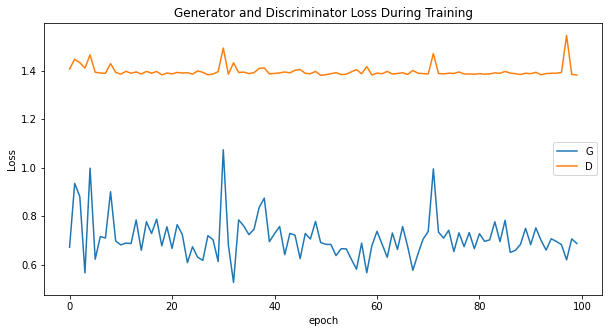

In [37]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

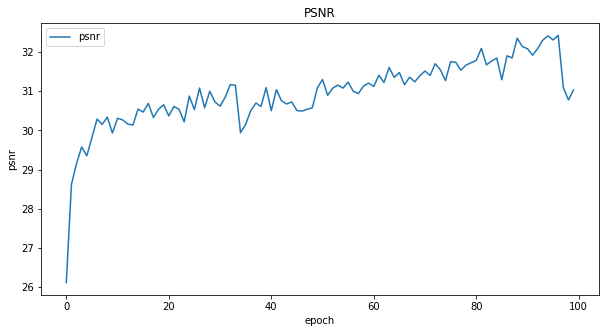

In [38]:
plt.figure(figsize=(10,5))
plt.title("PSNR")
plt.plot(p,label="psnr")
plt.xlabel("epoch")
plt.ylabel("psnr")
plt.legend()
plt.show()

# 학습 image 시각화

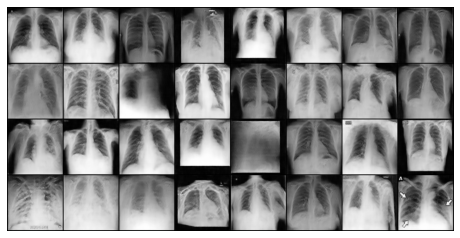

In [40]:
#%%capture
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


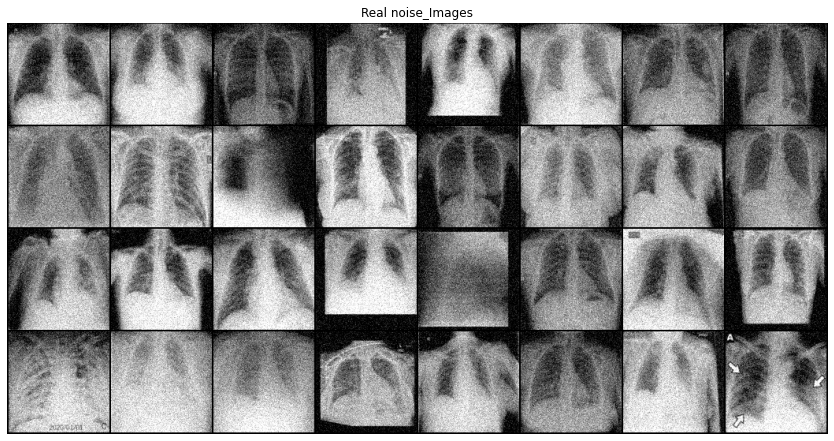

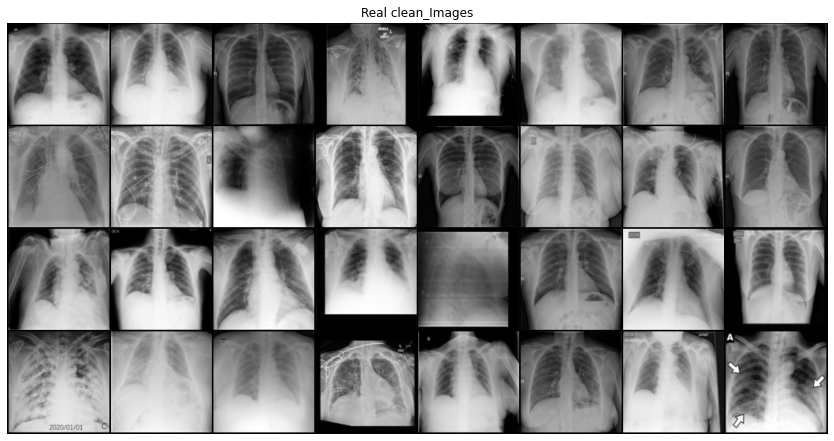

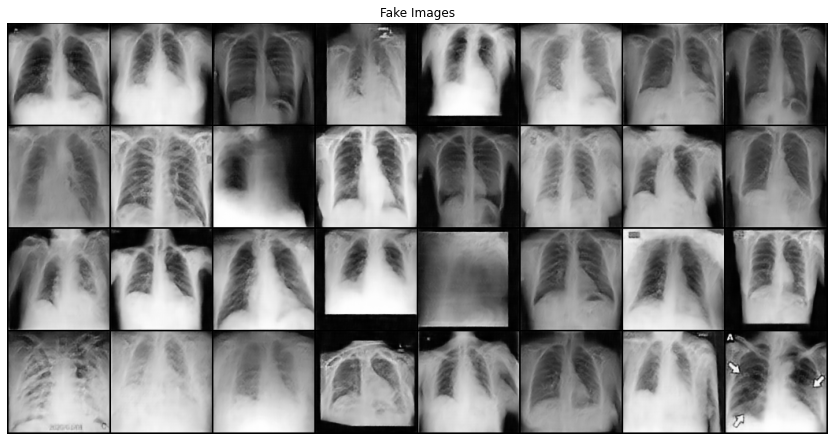

In [41]:
# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(50,50))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real noise_Images")
plt.imshow(np.transpose(utils.make_grid(real_a.float().to(device)).cpu(),(1,2,0)))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(50,50))
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Real clean_Images")
plt.imshow(np.transpose(utils.make_grid(real_b.to(device)).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(50,50))
plt.subplot(1,3,3)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Test data

In [36]:
# 가중치 저장
path2models = './폴더명/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'UDCGAN_G.pt')
path2weights_dis = os.path.join(path2models, 'UDCGAN_D.pt')

torch.save(netG.state_dict(), path2weights_gen)
torch.save(netD.state_dict(), path2weights_dis)

In [37]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
netG.load_state_dict(weights)

<All keys matched successfully>

In [38]:
# evaluation model
netG.eval()
f= []
r = []
n = []
# 가짜 이미지 생성
with torch.no_grad():
    for x in test_loader:
        real_test_a = add_noise("gauss",x).to(device)
        n.append(real_test_a)
        fake_imgs = netG(real_test_a.float()).cpu()
        f.append(fake_imgs)
        real_imgs = x
        r.append(real_imgs)

# Test data image 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


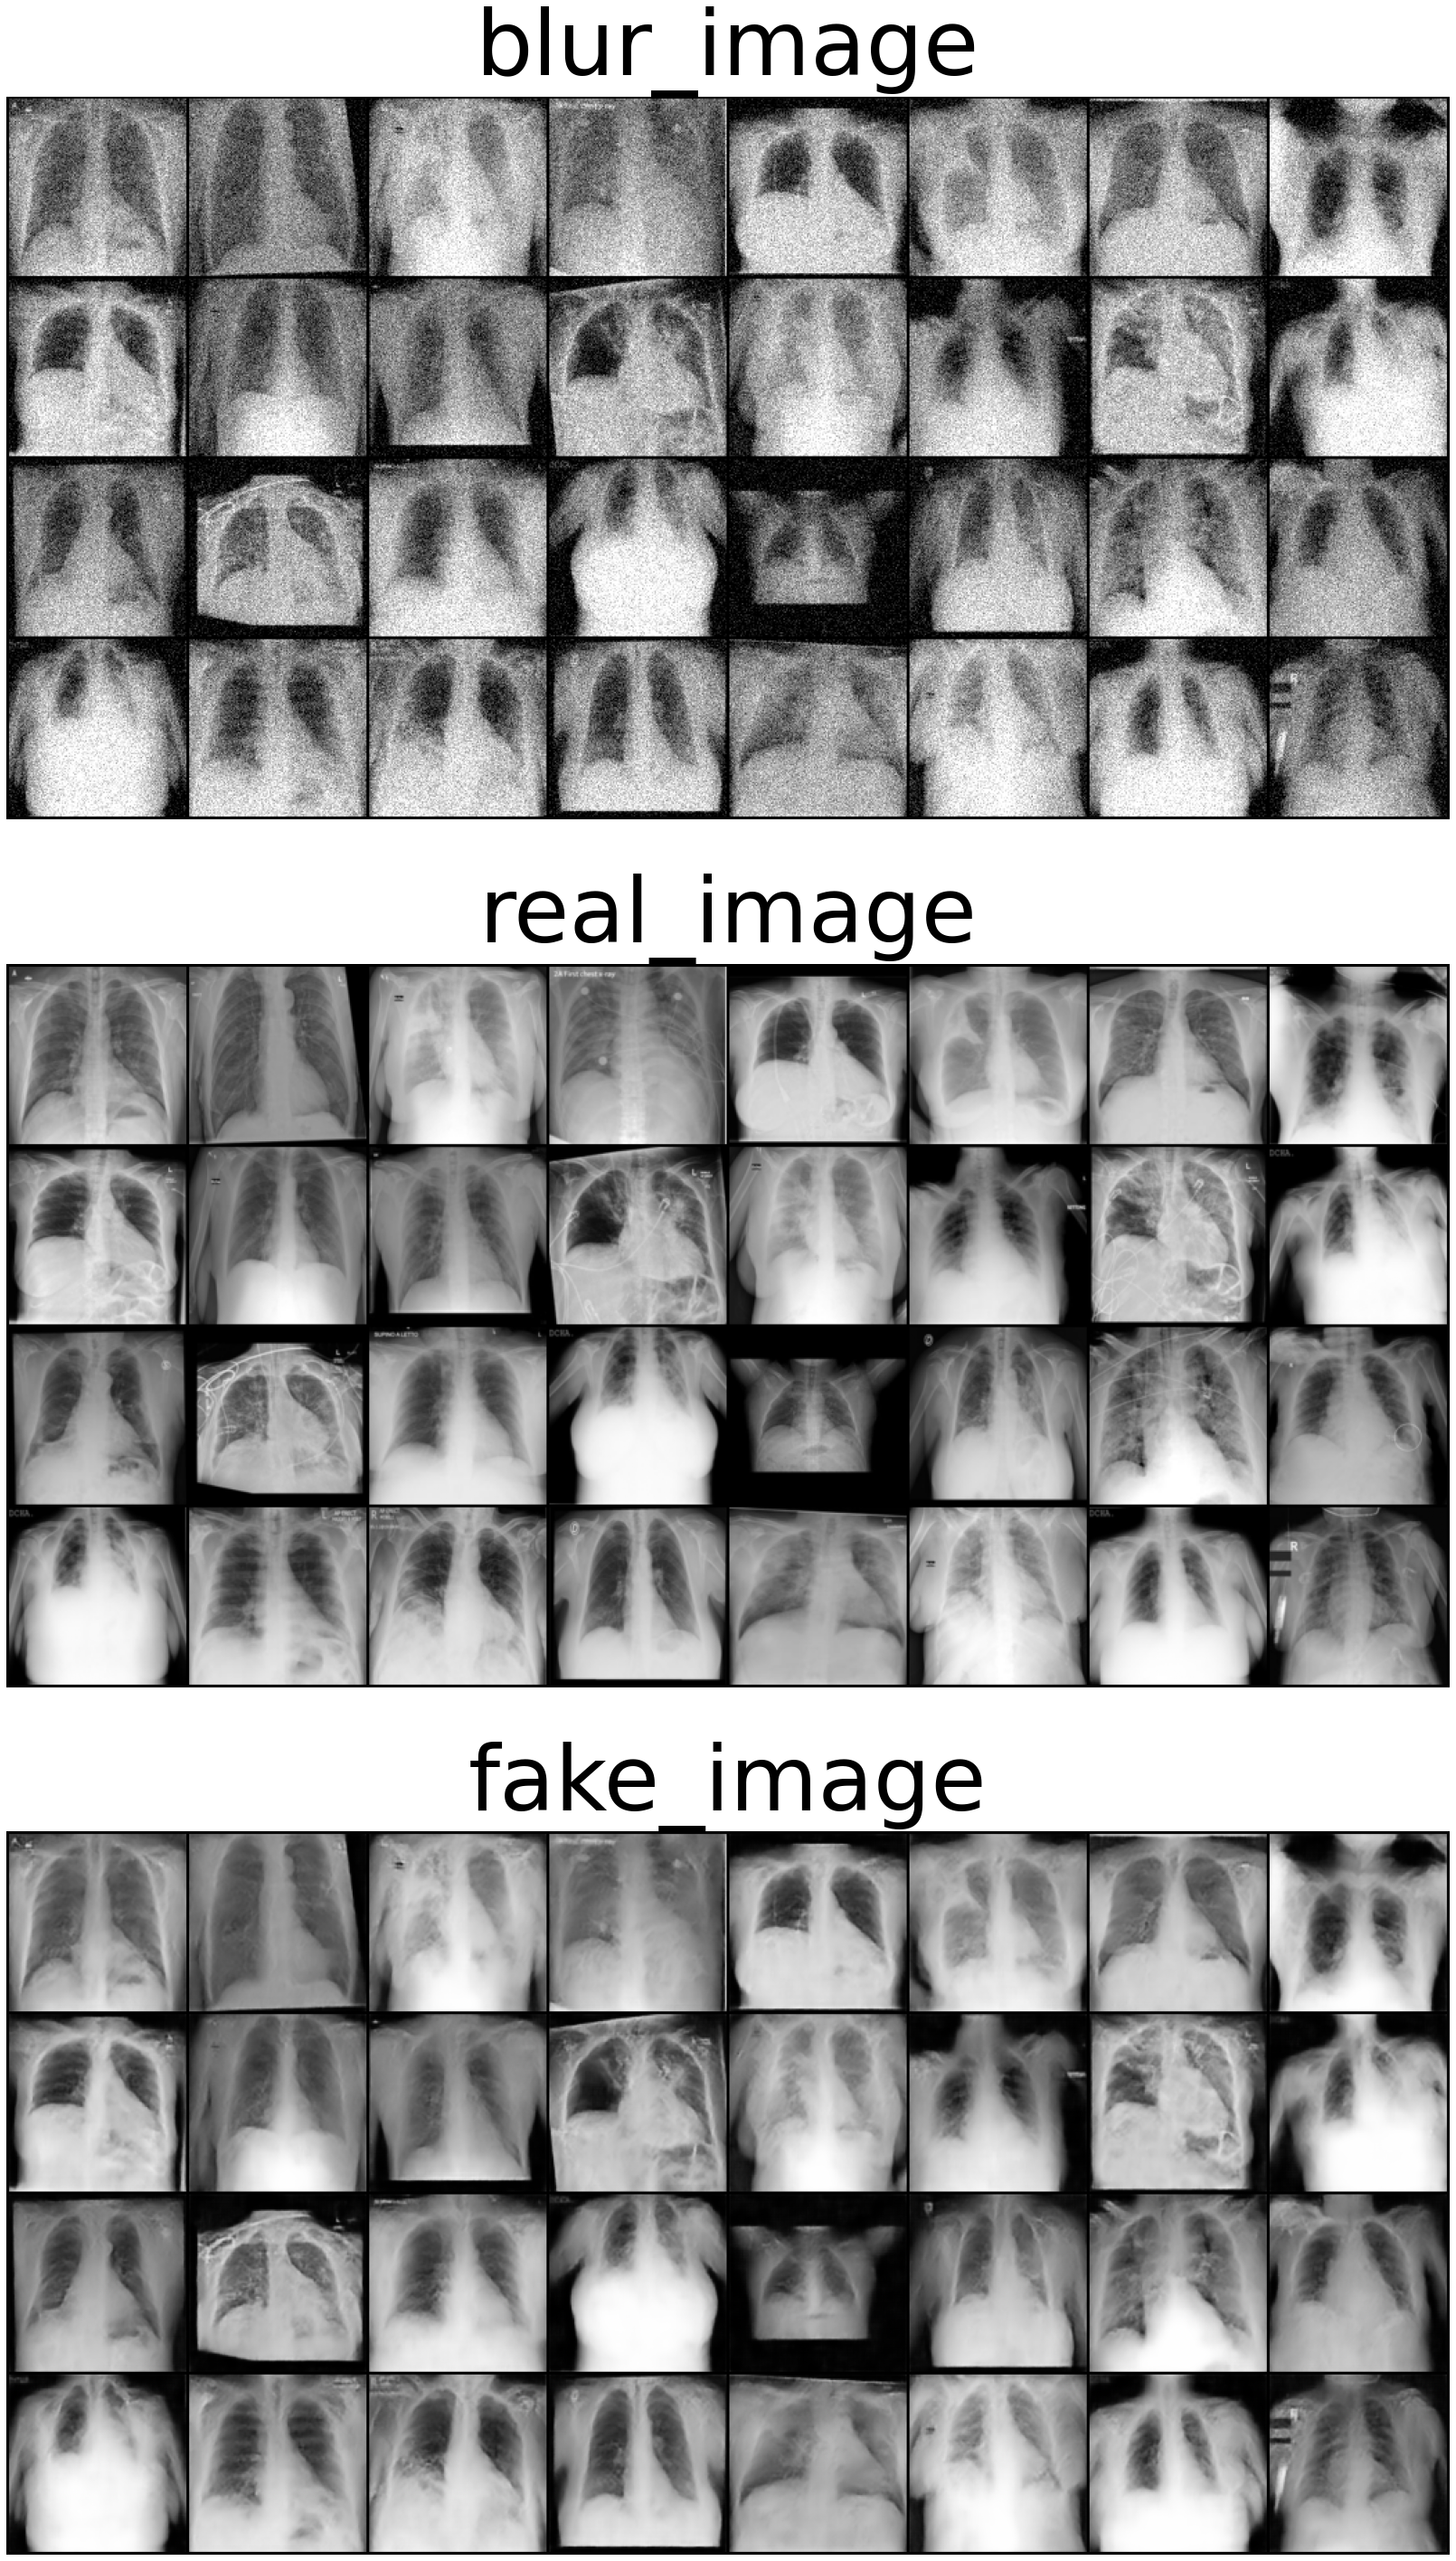

In [39]:
# 가짜 이미지 시각화
plt.figure(figsize=(50,50))

for ii in range(0,8,4):
    plt.subplot(3,1,1)
    plt.title('blur_image',fontsize= 100)
    plt.imshow(np.transpose(utils.make_grid(n[ii]).cpu(),(1,2,0)))
    plt.axis('off')
    plt.subplot(3,1,2)
    plt.title('real_image',fontsize= 100)
    plt.imshow(np.transpose(utils.make_grid(r[ii]).cpu(),(1,2,0)))
    plt.axis('off')
    plt.subplot(3,1,3)
    plt.title('fake_image',fontsize= 100)
    plt.imshow(np.transpose(utils.make_grid(f[ii]).cpu(),(1,2,0)))
    plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

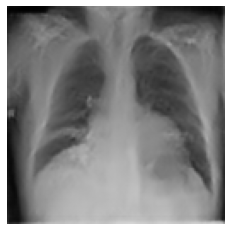

In [40]:
plt.imshow(np.transpose(utils.make_grid(f[0][7]).cpu(),(1,2,0)))
plt.axis('off')

### PSNR

In [41]:
res_psnr = []
for i in range(len(r)):
    for j in range(22):
        res_psnr.append(PSNR(r[i][j], f[i][j]))

In [44]:
np.mean(res_psnr)

32.08251531347349

### SSIM

In [59]:
from skimage.metrics import structural_similarity as ssim # image로 읽어와야함
res_ssim = []
for i in range(len(r)):
    # 마지막에 들어가는 batch_size 크기만큼 반복
    for j in range(22):
        c = r[i][j].squeeze()
        d =  f[i][j].squeeze()
        score = ssim(np.array(c), np.array(d))
        res_ssim.append(score)

In [62]:
np.mean(res_ssim)

0.9376618222690684

### MAE

In [63]:
mae_loss = nn.L1Loss()
res_mae = []
for i in range(len(r)):
    for j in range(22):
        res_mae.append(mae_loss(r[i][j], f[i][j]))
    
np.mean(res_mae)

MAE


0.018890232